# Digital Image Processing (CSE/ECE 478) Monsoon-2019

Solutions for DIP Assignment-1 on

1. Pixel Manipulation
1. Contrast Stretching 
1. Bits Manipulation
1. Intensity Transformation
1. Histogram Equalization and Matching
1. Histogram Transformation 

### Importing dependency libraries

In [1]:
import numpy as np
import cv2
import os,sys
from matplotlib import pyplot as plt
from operator import itemgetter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from collections import Counter

%matplotlib inline

### Utility functions

In [2]:
def getColorSpaces(image):
    rgb = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    return rgb,gray

def getImageDimnesion(image):
    height,width = image.shape[:2]
    
    return height,width

def showImage(image,title,cmap):
    plt.imshow(image,cmap=cmap)
    plt.axis('off')
    plt.title(title)


def splitRGBChannels(image):
  red, green, blue= cv2.split(img)
  
  return red, green, blue

 # <center>Question 1 -Pixel Manipulation </center>

### Write a function that takes a color image and finds the most frequently occurring color from the image.
Approach: 
1. Cluster the image using KMeans clustering
1. Centroids in the RGB space of the image represent dominant color of that cluster
1. Centroid of the largest cluster will be a pretty good representation of the image’s dominant color

In [3]:
def frequentColors(rgb,k):
    #reshaping to a list of pixels
    height,width=getImageDimnesion(rgb)
    array_pixel = np.reshape(rgb, (-1,3))
    
    #using k-means to cluster pixels
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(array_pixel)
    
    #returning after converting to integer from float
    return kmeans.cluster_centers_.astype(int),kmeans.labels_

**Function to return top K (no of clusters ) by looking at theri frequnecies**

In [4]:
def getColorBar(num_of_clusters ,labels,freq_colors):    
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, num_of_clusters+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(labels, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = freq_colors
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        color_bar = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(num_of_clusters):
            end = start + hist[i] * 500            
            r,g,b = tuple ([int(x) for x in colors[i]])
            #using cv2.rectangle to plot colors
            cv2.rectangle(color_bar, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        cv2.rectangle(color_bar, (0, 0), (500, 8), (0,0,0), -1)    
        return color_bar

In [5]:
img = cv2.imread( r'.\input_data\squares.jpg')
rgb,_=getColorSpaces(img) # Get image in RGB format
height,width=getImageDimnesion(rgb) #Get image dimensions

#Declare number of clusters for KMeans
num_of_clusters = 5
freq_colors,labels= frequentColors(rgb, num_of_clusters) 

print('Most frequent color  is ' ,freq_colors[0])

Most frequent color  is  [ 35 176  77]


### Extras

In [6]:
print('Top ' +str(num_of_clusters) +' Frequent colors \n' ,freq_colors)

Top 5 Frequent colors 
 [[ 35 176  77]
 [236  27  36]
 [  1 162 230]
 [214 215 213]
 [253 241   2]]


**Display top K (no of clusters ) by using a custom colorbar**

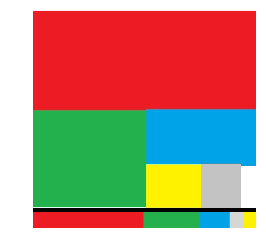

In [7]:
color_bar=getColorBar(num_of_clusters ,labels,freq_colors)

#Resize the color bar so that it has same width of input image
resized_color_bar = cv2.resize(color_bar, (width,height//10), interpolation=cv2.INTER_AREA)
#Stack the colorbar below the original image
image_with_color_bar=cv2.vconcat([rgb,resized_color_bar])

#display chart
plt.figure()
plt.axis("off")
plt.imshow(image_with_color_bar)
plt.show()

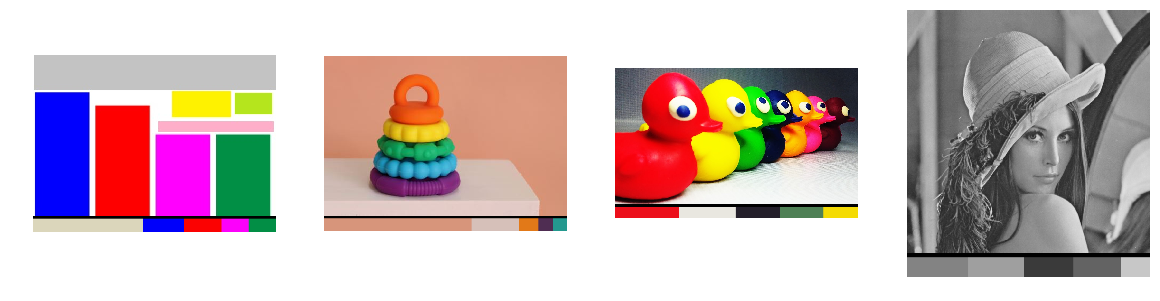

In [8]:
images_path=r'.\input_data'
images=['bargraph.jpg','rings.jpg','duck.jpg','lena.jpg']

images=[os.path.join(images_path,filename) for filename in images]

cols = len(images)
num=0
plt.figure(figsize=(20, 20))  
    
for img in images:
    img = cv2.imread(img)
    rgb,_=getColorSpaces(img) # Get image in RGB format
    height,width=getImageDimnesion(rgb) #Get image dimensions

    #Declare number of clusters for KMeans
    num_of_clusters = 5
    freq_colors,labels= frequentColors(rgb, num_of_clusters) 

    color_bar=getColorBar(num_of_clusters ,labels,freq_colors)

    #Resize the color bar so that it has same width of input image
    resized_color_bar = cv2.resize(color_bar, (width,height//10), interpolation=cv2.INTER_AREA)
    #Stack the colorbar below the original image
    image_with_color_bar=cv2.vconcat([rgb,resized_color_bar])

    plt.subplot(1,cols,num+1)    
    plt.axis('off')   
    plt.imshow(image_with_color_bar)

    num=num+1

### Write a function mergeImage which takes two images fg and bg that extracts the foreground object and places it in the background and returns the resultant image
***Approach***
1. Threshold the HSV image to get only green color 
1. hue_mask_source is equal to 255 where color between lower_green & upper_green [background],otherwise it is zero [foreground]
1. Generate Panchromatic image by inverting the values of FG and BG of hue_mask_source
1. From original green screen image, identify the foreground identified by using hue_mask_source as cookie cutter
1. Make a hole in the target image to the extent of source FG boundary
1. Add Source FG and background image

In [9]:
def mergeImage(green_frame,target_frame):
    
    print('Started Chroma Keying..')
         
    lower_green = np.array([50])
    upper_green = np.array([70]) 

    height, width, bands = target_frame.shape
    rows,cols,channels = green_frame.shape
    # cols-1 and rows-1 are the coordinate limits.
    
    #Translating fore- ground to match background video context
    M = np.float32([[1,0,200],[0,1,100]])
    green_frame = cv2.warpAffine(green_frame,M,(cols,rows), borderMode=cv2.BORDER_CONSTANT,
                               borderValue=(0,255,0))

    # BGR to HSV
    hsv = cv2.cvtColor(green_frame, cv2.COLOR_BGR2HSV)
    # HSV bands
    h = hsv[:,:,0]
    #s = hsv[:,:,1]
    #v = hsv[:,:,2]
    
    #Threshold the HSV image to get only green color
    #hue_mask_source is 255 where color between lower_green & upper_green [background]
    #otherwise it is zero [foreground]
    hue_mask_source = cv2.inRange(h, lower_green, upper_green) 
            
    #Generate Panchromatic image by inverting the values of FG and BG of hue_mask_source
    #Background is 0
    #Foreground is 255
    hue_masked_source_image=np.where(hue_mask_source != 0,0,255)
    
   
    # From original green screen image, identify the foreground identified by using hue_mask_source as cookie cutter
    masked_image = np.copy(green_frame)
    masked_image[hue_masked_source_image == 0] = [0, 0, 0]

    #Make a hole in the target image to the extent of source FG boundary
    output_video_frame = target_frame.copy()
#     output_video_frame=cv2.resize(output_video_frame,(640,360))
    output_video_frame[hue_masked_source_image != 0] = [0, 0, 0]
    #Add Source FG and background image
    output_video_frame = output_video_frame + masked_image
    
#     output_video_frame=cv2.resize(output_video_frame,(640,360))
       
    print('\nCompleted Chorma keying')
    
    return output_video_frame

Started Chroma Keying..

Completed Chorma keying


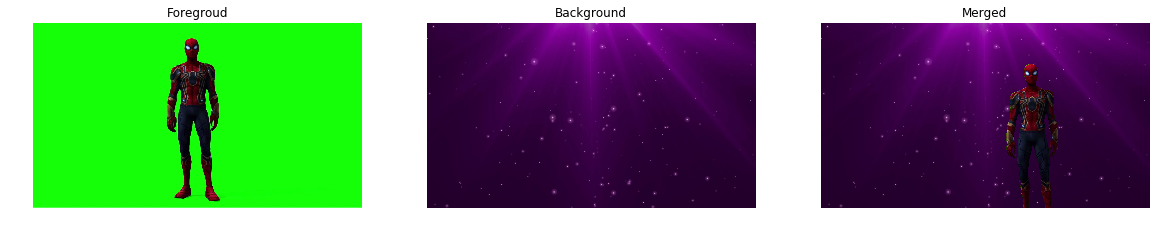

In [10]:
images=[]
titles=[]
fg=r'.\input_data\fg.jpg'
bg=r'.\input_data\bg.jpg'

green_frame=cv2.imread(fg)
green_frame_rgb,_=getColorSpaces(green_frame)

target_frame=cv2.imread(bg)
target_frame_rgb,_=getColorSpaces(target_frame)

assert(green_frame.shape==target_frame.shape) #Ensure green screen image and foreground image are of same size
merged_image=mergeImage(green_frame_rgb,target_frame_rgb)

images=[green_frame_rgb,target_frame_rgb,merged_image]
titles=["Foregroud","Background","Merged"]

num=0
plt.figure(figsize=(20, 20))

for img,title in zip(images,titles):
    plt.subplot(1,3,num+1)
    plt.axis('off')
    plt.title(title)   
    plt.imshow(img)
    num=num+1

### Try out with different foreground and background images of your choice and show the results.

Started Chroma Keying..

Completed Chorma keying
Started Chroma Keying..

Completed Chorma keying
Started Chroma Keying..

Completed Chorma keying


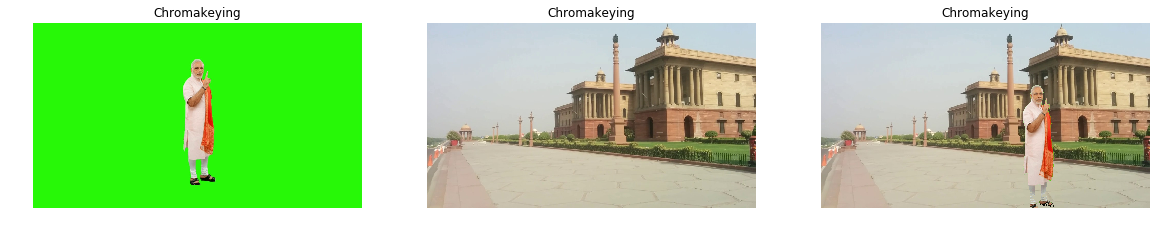

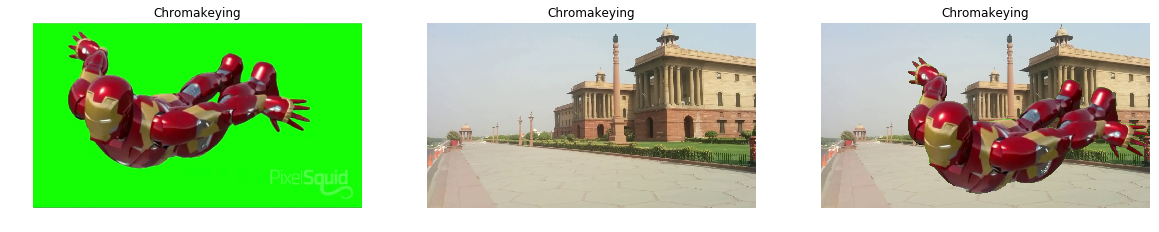

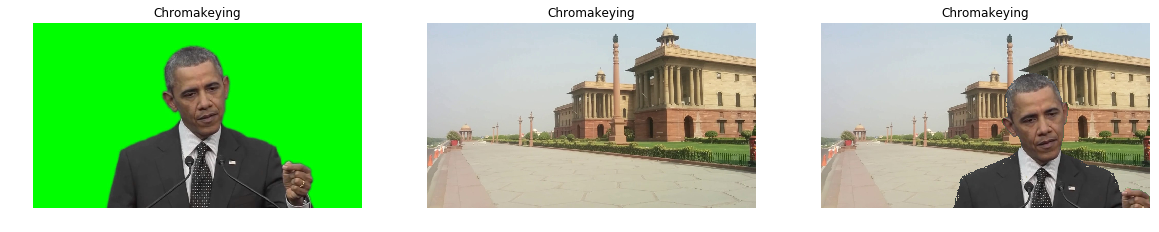

In [11]:
images_path=r'.\input_data\chromakeying'
images_fg=['modiji.jpg','ironman.jpg','obama.jpg']
images_bg=['parliament_bg.jpg','parliament_bg.jpg','parliament_bg.jpg']

images_fg=[os.path.join(images_path,filename) for filename in images_fg]
images_bg=[os.path.join(images_path,filename) for filename in images_bg]


for fg,bg in zip(images_fg,images_bg):
    green_frame=cv2.imread(fg)
    green_frame_rgb,_=getColorSpaces(green_frame)

    target_frame=cv2.imread(bg)
    target_frame_rgb,_=getColorSpaces(target_frame)

    assert(green_frame.shape==target_frame.shape) #Ensure green screen image and foreground image are of same size
    merged_image=mergeImage(green_frame_rgb,target_frame_rgb)

    images=[green_frame_rgb,target_frame_rgb,merged_image]
    titles=["Foregroud","Background","Merged"]
    img=cv2.hconcat([green_frame_rgb,target_frame_rgb,merged_image])
    
    num=0
    plt.figure(figsize=(20, 20))

    for img,title in zip(images,titles):
        plt.subplot(1,3,num+1)
        plt.axis('off')
        plt.title('Chromakeying')   
        plt.imshow(img)
        num=num+1

Artifacts observed 
1.	Potential causes - Lighting, shadows, variation of color shades 
1.	Majority of issues are occurring close to boundary of the object of interest
1.	Dark shades are causing issues

Improved result in some cases using HSV or RGB
 
Noticed that script of HSV computations is replaced by RGB script as below,provided better result in some cases.

        rgb = cv2.cvtColor(green_frame, cv2.COLOR_BGR2RGB)
        blues = rgb[:,:,0]
        greens = rgb[:,:,1]
        reds = rgb[:,:,2]
        
        hue_masked_source_image=((greens<220)|(reds>=greens)|(blues>=greens))*255

#  <center>Question 2 - Contrast Stretching </center>

### 1. Write a function linContrastStretching which takes a grayscale image im, a and b that enhances the contrast such that the resulting intensity range is [a; b] .
### 2.  Display the input image and the resultant image side-by-side along with their colorbars (a strip containing k most frequently occurring colors). Give suitable explanation for the resulting colorbars.
### 3. Use your function on multiple images and argue why the eect is more on some images while it is not that apparent on the others.

Approach:
In raw imagery, the useful data often populates only a small portion of the available range of digital values (commonly 8 bits or 256 levels). Contrast enhancement involves changing the original values so that more of the available range is used, thereby increasing the contrast between targets and their backgrounds. 

Linear contrast stretch  involves identifying lower and upper bounds from the histogram (usually the minimum and maximum brightness values in the image) and applying a transformation to stretch this range to fill the full range. In our example, the minimum value (occupied by actual data) in the histogram is 89 and the maximum value is 163. These 74 levels occupy less than one-third of the full 256 levels available.

A linear stretch uniformly expands this small range to cover the full range of values from 0 to 255. 

This enhances the contrast in the image with light toned areas appearing lighter and dark areas appearing darker, making visual interpretation much easier.

![title](.\input_data\linstre.gif)

Contrast stretching is given by the forumla where c and d are lowest and highest pixels values of input image and and b are of output image.
![title](.\input_data\eqnstr1.gif)
If is implemened in the function below.

In [14]:
def linContrastStretching(image_gray,a,b):    
    c = np.amin(image_gray)
    d = np.amax(image_gray)

    out_image =image_gray- c
    out_image *= int((b-a)/(d - c))
    out_image+=a
    
    return out_image

Text(20,600,'Min 0')

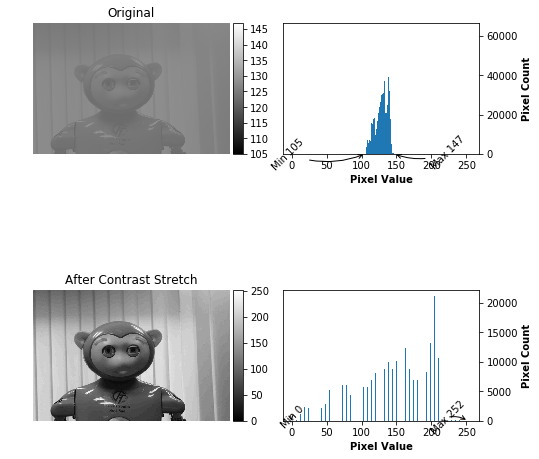

In [15]:
img_path=  r'.\input_data\contrast1.jpg'
img = cv2.imread(img_path)
rgb,gray=getColorSpaces(img)
a,b=0,255

contrast_enhanced_img=linContrastStretching(gray,a,b) # Get contrast stretched image

# Display Original image with colorbar and Histogram
fig = plt.figure(figsize=(8, 9))
axImage1 = fig.add_subplot(211)
axImage1.set_title('Original')
axImage1.axis('off')
im1 = axImage1.imshow(img, interpolation='None',cmap='gray')
divider = make_axes_locatable(axImage1)
axColorbar1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=axColorbar1, orientation='vertical')
axHist1 = divider.append_axes("right", '100%', pad='20%')
axHist1.yaxis.set_label_position("right")
axHist1.yaxis.tick_right()
axHist1.set_xlabel('Pixel Value', fontweight='bold')
axHist1.set_ylabel('Pixel Count', fontweight='bold')
axHist1.hist(img.ravel(),256,[0,256])
xmax=img.max()
axHist1.annotate('Max '+str(xmax), xy=(xmax, 0), xytext=(250, 600),rotation=45,
                   va="center", ha="right", textcoords='data',xycoords='data',                 
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2",fc="w"),  )
xmin=img.min()
axHist1.annotate('Min '+str(xmin), xy=(xmin, 0), xytext=(20,60),rotation=45,
                   va="center", ha="right", textcoords='data',xycoords='data',                 
                  arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.2",fc="w"),  )

#Display image after contrast stretch
axImage2 = fig.add_subplot(212)
axImage2.set_title('After Contrast Stretch')
axImage2.axis('off')
im2 = axImage2.imshow(contrast_enhanced_img, interpolation='None',cmap='gray')
divider = make_axes_locatable(axImage2)
axColorbar2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=axColorbar2, orientation='vertical')
axHist2 = divider.append_axes("right", '100%', pad='20%')
axHist2.yaxis.set_label_position("right")
axHist2.yaxis.tick_right()
axHist2.set_xlabel('Pixel Value',fontweight='bold')
axHist2.set_ylabel('Pixel Count', fontweight='bold')
axHist2.hist(contrast_enhanced_img.ravel(),256,[0,256])
xmax=contrast_enhanced_img.max()
axHist2.annotate('Max '+str(xmax), xy=(xmax, 0), xytext=(250,600),rotation=45,
                   va="center", ha="right", textcoords='data',xycoords='data',                 
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2",fc="w"),  )
xmin=contrast_enhanced_img.min()
axHist2.annotate('Min '+str(xmin), xy=(xmin, 0), xytext=(20,600),rotation=45,
                   va="center", ha="right", textcoords='data',xycoords='data',                 
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2",fc="w"),  )

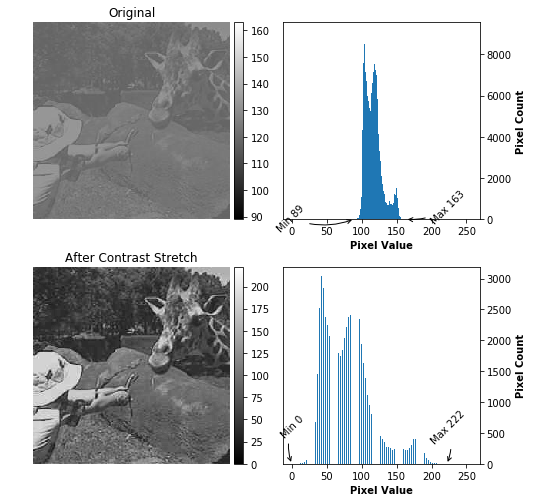

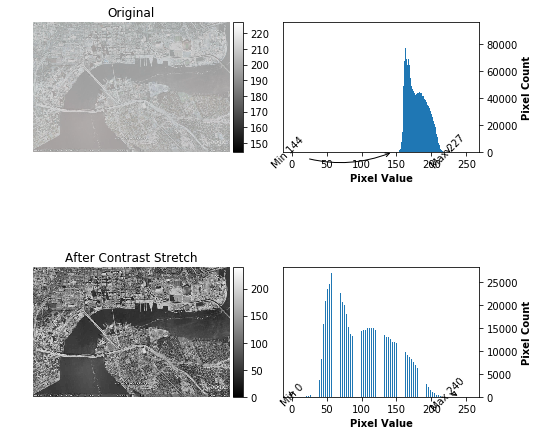

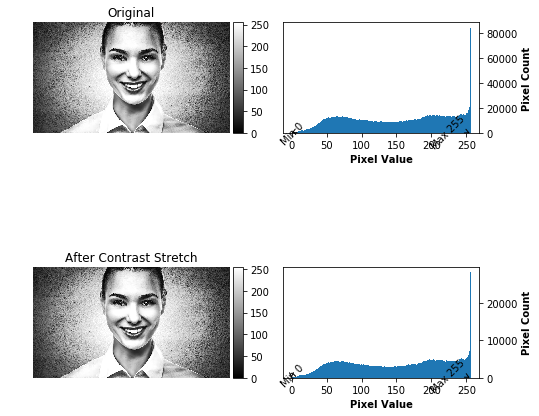

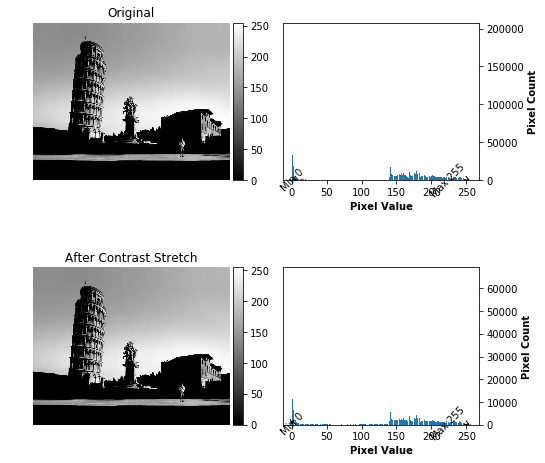

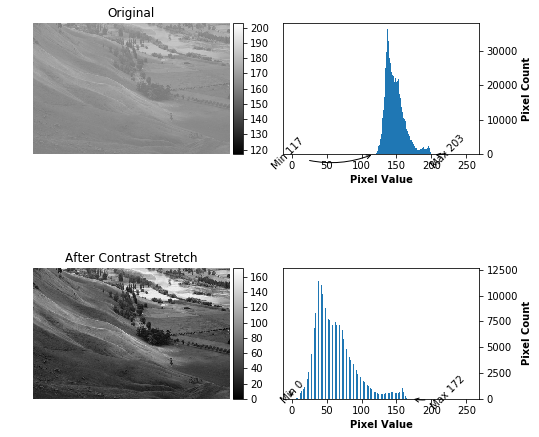

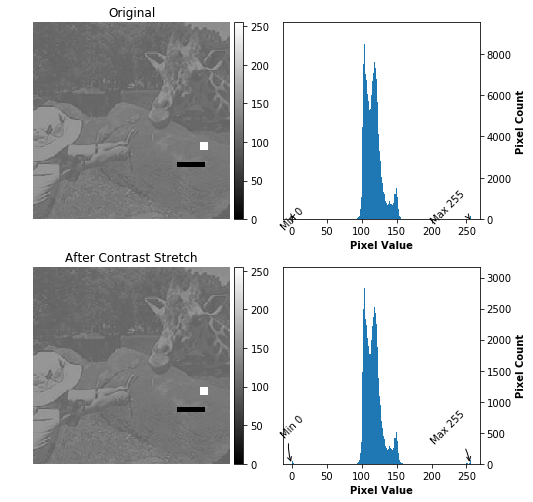

In [110]:
images_path=r'.\input_data\'
images=['contrast2.jpg','contrast3.jpg','contrast4.jpg','contrast5.jpg','contrast6.jpg','contrast2_2.jpg']

images=[os.path.join(images_path,filename) for filename in images]

cols = len(images)
num=0
plt.figure(figsize=(8, 8))  

for img_path in images:
    img = cv2.imread(img_path)
    rgb,gray=getColorSpaces(img)
    a,b=0,255

    contrast_enhanced_img=linContrastStretching(gray,a,b) # Get contrast stretched image

    # Display Original image with colorbar and Histogram
    fig = plt.figure(figsize=(8, 9))
    axImage1 = fig.add_subplot(211)
    axImage1.set_title('Original')
    axImage1.axis('off')
    im1 = axImage1.imshow(img, interpolation='None',cmap='gray')
    divider = make_axes_locatable(axImage1)
    axColorbar1 = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=axColorbar1, orientation='vertical')
    axHist1 = divider.append_axes("right", '100%', pad='20%')
    axHist1.yaxis.set_label_position("right")
    axHist1.yaxis.tick_right()
    axHist1.set_xlabel('Pixel Value', fontweight='bold')
    axHist1.set_ylabel('Pixel Count', fontweight='bold')
    axHist1.hist(img.ravel(),256,[0,256])
    xmax=img.max()
    axHist1.annotate('Max '+str(xmax), xy=(xmax, 0), xytext=(250, 600),rotation=45,
                       va="center", ha="right", textcoords='data',xycoords='data',                 
                      arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2",fc="w"),  )
    xmin=img.min()
    axHist1.annotate('Min '+str(xmin), xy=(xmin, 0), xytext=(20,60),rotation=45,
                       va="center", ha="right", textcoords='data',xycoords='data',                 
                      arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.2",fc="w"),  )
    plt.subplots_adjust(wspace=0, hspace=0)

    #Display image after contrast stretch
    axImage2 = fig.add_subplot(212)
    axImage2.set_title('After Contrast Stretch')
    axImage2.axis('off')
    im2 = axImage2.imshow(contrast_enhanced_img, interpolation='None',cmap='gray')
    divider = make_axes_locatable(axImage2)
    axColorbar2 = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=axColorbar2, orientation='vertical')
    axHist2 = divider.append_axes("right", '100%', pad='20%')
    axHist2.yaxis.set_label_position("right")
    axHist2.yaxis.tick_right()
    axHist2.set_xlabel('Pixel Value',fontweight='bold')
    axHist2.set_ylabel('Pixel Count', fontweight='bold')
    axHist2.hist(contrast_enhanced_img.ravel(),256,[0,256])
    xmax=contrast_enhanced_img.max()
    axHist2.annotate('Max '+str(xmax), xy=(xmax, 0), xytext=(250,600),rotation=45,
                       va="center", ha="right", textcoords='data',xycoords='data',                 
                      arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2",fc="w"),  )
    xmin=contrast_enhanced_img.min()
    axHist2.annotate('Min '+str(xmin), xy=(xmin, 0), xytext=(20,600),rotation=45,
                       va="center", ha="right", textcoords='data',xycoords='data',                 
                      arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2",fc="w"),  )

Observations
1. An image of low contrast has a small difference between its dark and light pixel values. 
1. The histogram of a low contrast image is usually skewed either to the left (mostly light), to the right (mostly dark), or located around the right (mostly gray).

### Why the effect is more on some images while it is not that apparent on the others ?

This algorithm fails on some cases. 
1. Images with when there is pixel intensity 0 and 255 are present in the input image  .That means the output image is equal to the processed image. That means there is no effect of histogram stretching has been done at this image.
1. This technique works best when the histogram of the image is Gaussian.
1. A single outlying pixel with either a very high or very low value can severely affect the value of c or d and this could lead to very unrepresentative scaling


#  <center>Question 3 - Bits Manipulation </center>

###  Write a function BitQuantizeImage which takes an 8-bit image im and k, the number of bits to which the image needs to be quantized to and returns the k-bit quantized image. Display results for the image quantize.jpg

Approach used is to divide (integer division) by a factor N the image, and then multiply by a factor N, where N=2**K and 
K is the number of bits

In [16]:
def BitQuantizeImage(img,k):
    quant_img=img.copy()
    N=2**k
    quant_img=quant_img/256
    quant_img=np.floor(quant_img* N).astype('uint8')
    return quant_img/N

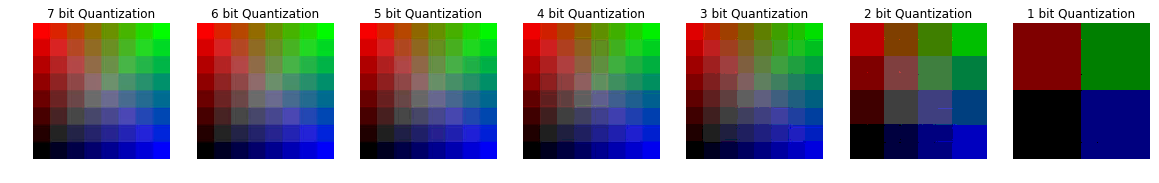

In [17]:
imga_path=r'.\input_data\quantize.jpg'
image = cv2.imread(imga_path)
cols = 7
num=0
plt.figure(figsize=(20, 20))
    
for k in range(7, 0, -1):   
    plt.subplot(1,cols,num+1)    
    plt.axis('off')
    plt.title(str(k) + " bit Quantization")    
    quant_img=BitQuantizeImage(image,k)    
    plt.imshow(quant_img)
    num=num+1

### Write a code to display different bit planes of an 8-bit gray-scale image. Display results for the image cameraman.png

In [18]:
def getBitPlane(image,bit_plane):
    img_bitplane = np.mod(np.floor(image/np.power(2, bit_plane)), 2)
    return img_bitplane

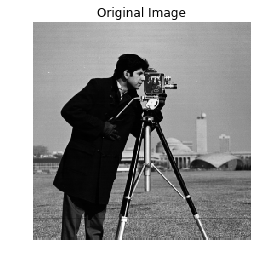

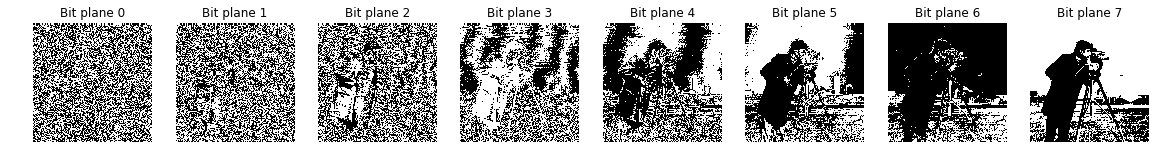

In [19]:
imge_path='.\input_data\cameraman.png'
image = cv2.imread(imge_path,0)

plt.title("Original Image")
plt.axis('off')
plt.imshow(image,cmap='gray')
plt.show()

plt.figure(figsize=(20, 20))
num=0
images=[]

for bit_plane in range(8):    
    plt.subplot(1,8,num+1) 
    plt.axis('off')
    plt.title("Bit plane " +str(bit_plane))    
    img=getBitPlane(image,bit_plane)   
    images.append(img)
    plt.imshow(img,cmap='gray')
    num=num+1   

## Extras

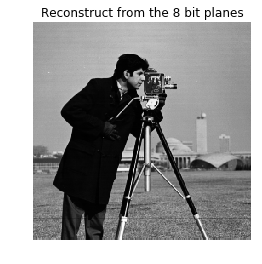

In [20]:
#Combine all bit planes, we will get the original image
new_img = (2 * (2 * (2 * (2 * (2 * (2 * (2 * images[7] + images[6]) 
+ images[5]) + images[4]) + images[3]) + images[2]) + images[1]) + images[0]); 
plt.title("Reconstruct from the 8 bit planes")
plt.axis('off')
plt.imshow(new_img,cmap='gray')
plt.show()    

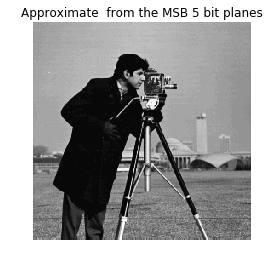

In [21]:
new_img =  (2 * (2 * (2 * (2 * images[7] + images[6]) + images[5]) + images[4]) + images[3])  
plt.title("Approximate  from the MSB 5 bit planes")
plt.axis('off')
plt.imshow(new_img,cmap='gray')
plt.show()    

### Given original image lena.jpg identify the operations applied on the images lena1.jpg,lena2.jpg and lena3.jpg.

In [24]:
images_path=r'.\input_data'
images=['lena.jpg','lena1.jpg','lena2.jpg','lena3.jpg']
operations=['Original','Bit Plane(4)','Bit Quantization','Binary Threshold']

images=[os.path.join(images_path,filename) for filename in images]
cols = len(images)
num=0

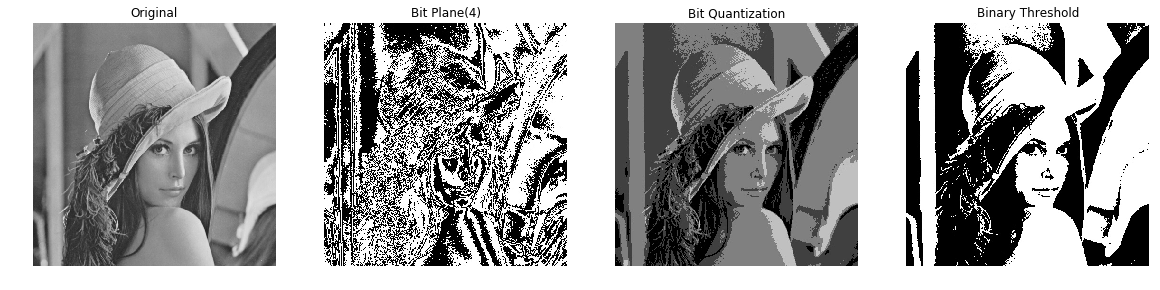

In [25]:
plt.figure(figsize=(20, 20))
for img_path,op in zip(images,operations):
    img = cv2.imread(img_path)
    rgb,gray=getColorSpaces(img)
    plt.subplot(1,cols,num+1) 
    plt.axis('off')
    plt.title(op)    
    plt.imshow(img)
    num=num+1       

#  <center>Question 4 - Intensity Transformation </center>

### Write a function to create the negative of an image. The function should take the image and maximum intensity as arguments. Produce the transformed output for first 8 k-bit quantized forms of lena.jpg.

In [27]:
def getImageNegative(img,k):
    quant_img=img.copy()
    N=2**k
    quant_img=quant_img/256
    quant_img=np.floor(quant_img* N).astype('uint8')
    negative_img=quant_img/N
    return N-negative_img

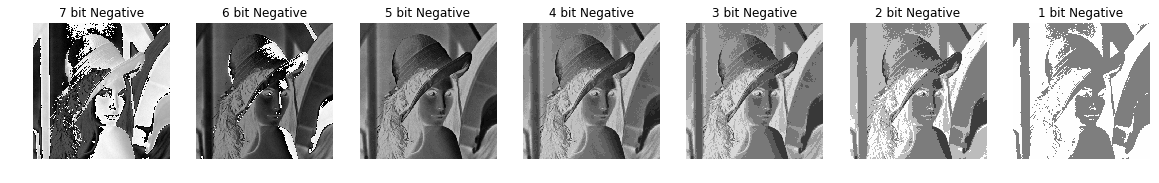

In [28]:
imge_path=r'.\input_data\lena.jpg'
image = cv2.imread(imge_path)
cols = 7
num=0
plt.figure(figsize=(20, 20))
    
for k in range(7, 0, -1):   
    plt.subplot(1,cols,num+1)    
    plt.axis('off')
    plt.title(str(k) + " bit Negative")    
    negative_img=getImageNegative(image,k)    
    plt.imshow(negative_img)
    num=num+1

### Using the image gamma-corr.png, apply the Gamma Transform s = r^gamma  and vary  'gamma' .Report your observations.

\begin{align}
s=r^{\gamma}
\end{align}

Where, ‘s’ and ‘r’ are the output and input pixel values, respectively and ‘c’ and γ are the positive constants.

In [29]:
def performGammaCorrection(img,gamma):

    gamma_corrected = ((img/255) **gamma)    
#    gamma_corrected = cv2.pow(img/255,gamma)
    return gamma_corrected

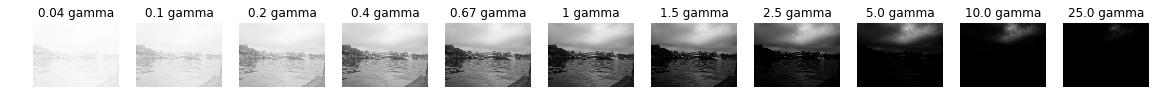

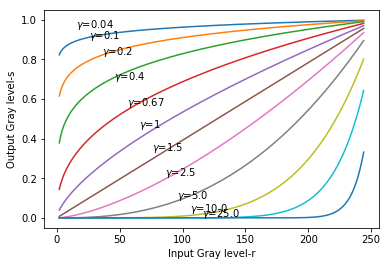

In [30]:
imge_path=r'.\input_data\gamma-corr.png'
image = cv2.imread(imge_path)

plt.figure(figsize=(20, 20))
num=0

lst_gammas=[0.04,0.10,0.20,0.40,0.67,1,1.5,2.5,5.0,10.0,25.0]
    
for gamma in lst_gammas:   
    plt.subplot(1,len(lst_gammas),num+1)    
    plt.axis('off')
    plt.title(str(gamma) + " gamma")    
    gamma_corrected=performGammaCorrection(image,gamma)    
    plt.imshow(gamma_corrected)
    num=num+1
plt.show()

xoffest=-100
for gamma in lst_gammas:   
    gamma_corrected=performGammaCorrection(image,gamma)    
    plt.xlabel('Input Gray level-r')   
    plt.ylabel('Output Gray level-s')
#    plt.axis('off')    
    plt.annotate(r'$\gamma$='+str(gamma), xy=(image.ravel().mean()+xoffest,gamma_corrected.ravel().mean()), xycoords='data')
    
    plt.plot(np.sort(image.ravel()),np.sort(gamma_corrected.ravel()))
    xoffest+=10
plt.show()


#### Observations:


Our eyes do not perceive light the way cameras do. With a digital camera, when twice the number of photons hit the sensor, it receives twice the signal (a "linear" relationship)

Our eyes perceive twice the light as being only a fraction brighter — and increasingly so for higher light intensities (a "nonlinear" relationship)

Thus, while a digital camera has a linear relationship between brightness our eyes have a non-linear relationship. In order to account for this relationship, we apply gamma correction.https://www.cambridgeincolour.com/tutorials/gamma-correction.htm

![title](.\input_data\gamma_chart1e.png)

1. As we increase the value of gamma, the image becomes darker, and vice versa.
1. γ > 1  Compresses dark values ;Expands bright values
1. γ < 1  Expands dark values ;Compresses bright values
1. In the 'r' vs 's' graph When γ < 1, the line arches upward, whereas the opposite occurs with γ >1

### Write a function to implement a piecewise linear transform g(z) = K1 * z + K2;  a<=z<=b. The function takes an input image, coefficients K1,K2 and intervals a,b for each linear segment and produces the transformed output image. Produce transformed outputs of lena.jpg for the following functions

In [59]:
from PIL import Image
# Input k1=float k2=float a=float b=float
# Output new_im=linear transformed image
def LinearTransform(im, k1, k2, a, b):

    # Update input for use for main use
    k1 = k1
    k2 = int(k2*255)
    a = int(a*255)
    b = int(b*255)

    # Get the dimensions of background image 
    im = np.array(im)

    new_im = k1*im + k2
    new_im[im > b] = 255
    new_im[im < a] = 0
    new_im[new_im > 255] = 255
    new_im[new_im < 0] = 0
    
    return new_im.astype('uint8')

In [73]:
def piecewise_linear_transform(im,k1_list,k2_list,a_list, b_list):
    #   Just for displaying purposes
    x = np.arange(0,1,0.01)
    y_list = []
    im_list = []
    for i in range(len(k1_list)):
        try:
            new_y = k1_list[i]*x + k2_list[i]
            new_y[ x < a_list[i]] = 0
            new_y[ x > b_list[i]] = 1
            
            new_im = LinearTransform(im,k1_list[i],k2_list[i],a_list[i],b_list[i])
            
            y_list.append(new_y)
            im_list.append(new_im)
            
        except Exception as e:
            print("Error while producing linear transform:",e)
    
    im_list = np.array(im_list)
    new_im = np.sum(im_list,axis=0)
    new_im[ new_im > 255] = 255
    new_im[ new_im < 0] = 0
    
    
    y_list = np.array(y_list)
    y = np.sum(y_list,axis=0)
    y[ y > 1] = 1
    y[ y < 0] = 0
    
    
#   Plot the graph, image
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)
    ax3 = fig.add_subplot(1,3,1)
    ax1.imshow(np.array(im), cmap='gray')
    ax2.imshow(np.array(new_im), cmap='gray')
    ax3.plot(x,y)
    ax1.set_title('Old Image')
    ax2.set_title('Transformed Image')
    ax3.set_title('Function')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('scaled')
    plt.show()

In [74]:

k1 = [2.0,0.0]
k2 = [0.0,-1.0]
# a = [0.25,0.75]
# b = [0.75,1.0]
a = [0.2,0.4]
b = [0.4,0.8]
from PIL import Image
im = Image.open(r'.\input_data\lena.jpg').convert('L')
#piecewise_linear_transform(im,k1,k2,a,b)

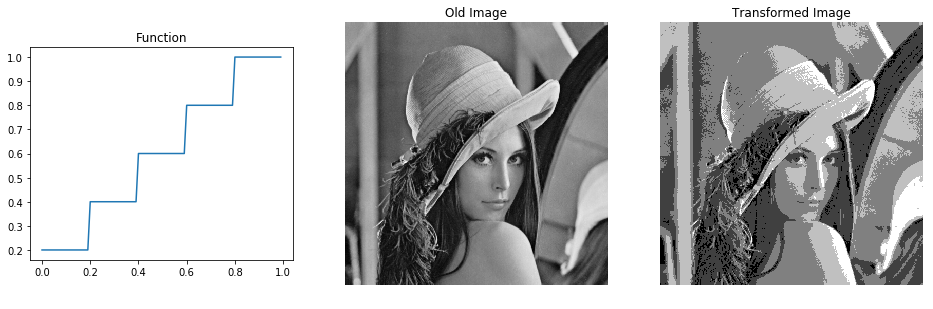

In [75]:

k1 = [0.0,0.0,0.0,0.0,0.0,0.0]
k2 = [0.2,0.2,0.2,0.2,0.2,0.2]
a = [0.0,0.2,0.4,0.6,0.8,1.0]
b = [1.0,1.0,1.0,1.0,1.0,1.0]
im = Image.open(r'.\input_data\lena.jpg').convert('L')
piecewise_linear_transform(im,k1,k2,a,b)

#  <center>Question 5 - Miscellaneous </center>

**What can you say about the histogram of a resulting image if we keep the MSB
bits in the bitplane to 0?**

For an 8-bit image, a pixel value of 0 is represented as 00000000 in binary form and 255 is encoded as 11111111. 

The bit in the far left side is referred as the most significant bit (MSB) because a change in that bit would significantly change the value encoded by the byte. The bit in the far right is referred as the least significant bit (LSB), because a change in this bit does not change the encoded gray value much. 

The higher-order bits (especially the top four) contain the majority of the visually significant data.The other bit planes contribute to more subtle details in the image.

It can be said that only the 5 most significant bits (MSB) contain visually significant data while the 3 less significant bit (LSB) planes contribute the more subtle details.

In [80]:
imge_path='.\input_data\cameraman.png'
image = cv2.imread(imge_path,0)
images=[]
for bit_plane in range(8):    
    img=getBitPlane(image,bit_plane)   
    images.append(img)
h,w=image.shape

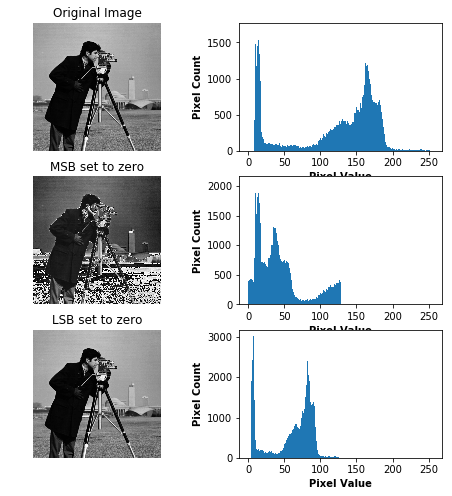

In [81]:
msb_img = np.zeros((h, w), np.uint8)
lsb_img = np.zeros((h, w), np.uint8)   

    
new_img = (2 * (2 * (2 * (2 * (2 * (2 * (2 * images[7] + images[6]) 
+ images[5]) + images[4]) + images[3]) + images[2]) + images[1]) + images[0]); 

lsb_img=  (2 * (2 * (2 * (2 * (2 * (2 * images[7] + images[6]) 
+ images[5]) + images[4]) + images[3]) + images[2]) + images[1]) 

msb_img = (2 * (2 * (2 * (2 * (2 * (2 * (images[6]) 
+ images[5]) + images[4]) + images[3]) + images[2]) + images[1]) + images[0]); 


plt.figure(figsize=(8, 8))

plt.subplot(3,2,1)
plt.title("Original Image")
plt.axis('off')
plt.imshow(image,cmap='gray')

plt.subplot(3,2,2)
plt.xlabel('Pixel Value',fontweight='bold')
plt.ylabel('Pixel Count', fontweight='bold')
plt.hist(image.ravel(),256,[0,256])

plt.subplot(3,2,3)
plt.title("MSB set to zero")
plt.axis('off')
plt.imshow(msb_img,cmap='gray')

plt.subplot(3,2,4)
plt.xlabel('Pixel Value',fontweight='bold')
plt.ylabel('Pixel Count', fontweight='bold')
plt.hist(msb_img.ravel(),256,[0,256])


plt.subplot(3,2,5)
plt.title("LSB set to zero")
plt.axis('off')
plt.imshow(lsb_img,cmap='gray')

plt.subplot(3,2,6)
plt.xlabel('Pixel Value',fontweight='bold')
plt.ylabel('Pixel Count', fontweight='bold')
plt.hist(lsb_img.ravel(),256,[0,256])

plt.show()    

1. Setting MSB bits to zero would mean the loss of very visually significant data from the image. 
1. Image becomes darker 
1. Hostogram shifted to darker region
1. Heights some of the remaining histogram peaks increased.
1. Skewed range reflects reduced contrast

** What can you say about the histogram of a resulting image if we keep the LSB bits
in the bitplane to 0? **

1. Histogram has reduced number of intensity levels and since the size of the image does not change, the histogram showing an increment in the number of pixels 
1. Histogram became sparse
1. Histogram appears same but in less range
1. Less variability in gray level values reduced contrast

** Transmission is usually achieved through packets containing a start bit, a byte of information and a stop bit.
Baud rate is a common measure for digital data transmission and is dened as number of bits transmitted per second.
How much time would it take to transmit 512 x 512 grayscale image with intensity 0-255 over a 56K baud link? 
Similarly, calculate the time required to transmit the same image over a 3000K baud link. **


In [82]:
def getTransferRate(imsize,intesity_bits,startstop_bits,baud_rate):    
    total_bits=intesity_bits+startstop_bits    
    time_taken=(imsize*total_bits)/(baud_rate)  # Convert to minutes by 60
    
    return time_taken

    
imsize=512*512
intesity_bits=8 # As intesnsity is 0-255 
startstop_bits=2 # Start bit and Stop bit
baud_rate=56000

time_taken=getTransferRate(imsize,intesity_bits,startstop_bits,baud_rate)
print('Time taken at baud rate :' ,baud_rate)
print('Seconds :' ,time_taken)

baud_rate=3000000
time_taken=getTransferRate(imsize,intesity_bits,startstop_bits,baud_rate)
print('Time taken at baud rate :' ,baud_rate)
print('Seconds :' ,time_taken)


Time taken at baud rate : 56000
Seconds : 46.81142857142857
Time taken at baud rate : 3000000
Seconds : 0.8738133333333333


#  <center>Question 6 - Histogram Equalization and Matching </center>

** Write a function histEqualization which takes a grayscale image im, and applies
histogram equalization on the entire image. **

In [83]:
def getHistogram(image, bins=256):
    
    image_pixels=image.flatten()
    # array with size of bins, set to zeros
    histogram = np.zeros(bins)
    
    # loop through pixels and sum up counts of pixels
    for pixel in image_pixels:
        histogram[pixel] += 1
    
    # return our final result
    return histogram

def getCDF(hist):
    
    cs=np.cumsum(hist)
    # numerator & denomenator
    nj = (cs - cs.min()) * 255
    N = cs.max() - cs.min()
    
    # re-normalize the cdf
    cs = nj / N
    cum_hist = cs.astype('uint8')
    
    return cum_hist


In [84]:
def histEqualization(im):

    h,w=im.shape
    hist = getHistogram(im)
    cum_hist = getCDF(hist)

    img_new = cum_hist[im.flatten()]
    img_new = np.reshape(img_new, im.shape)
    
    return img_new

** Display the input image and the resultant image side-by-side and provide suitable
explanation for the changes you observe for multiple input images. **

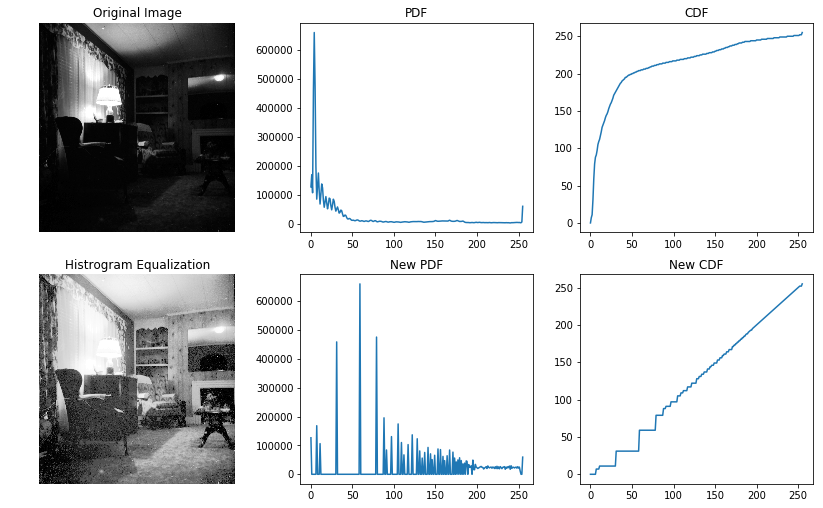

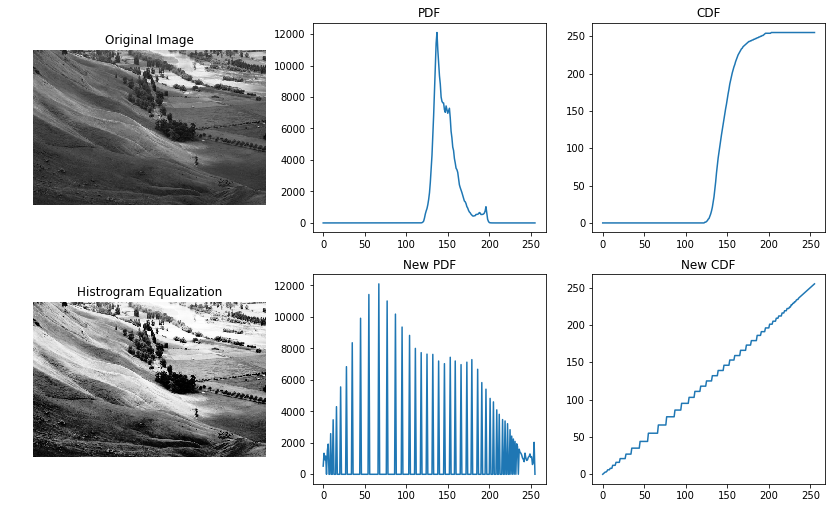

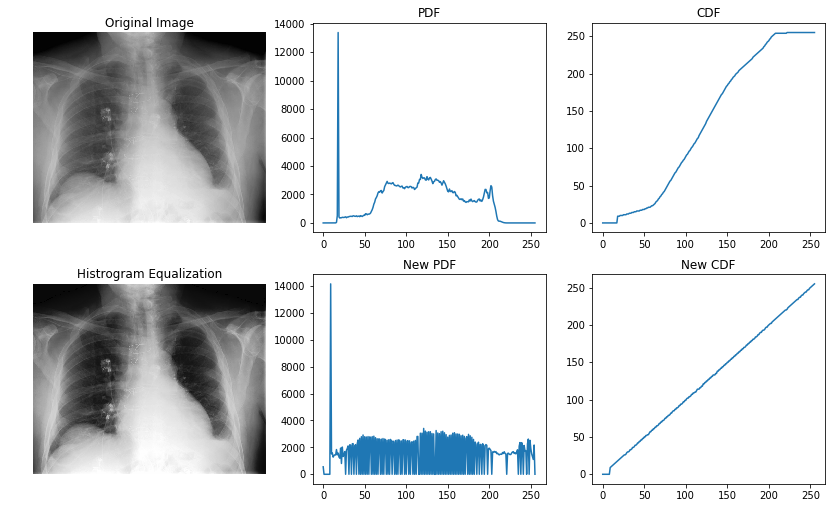

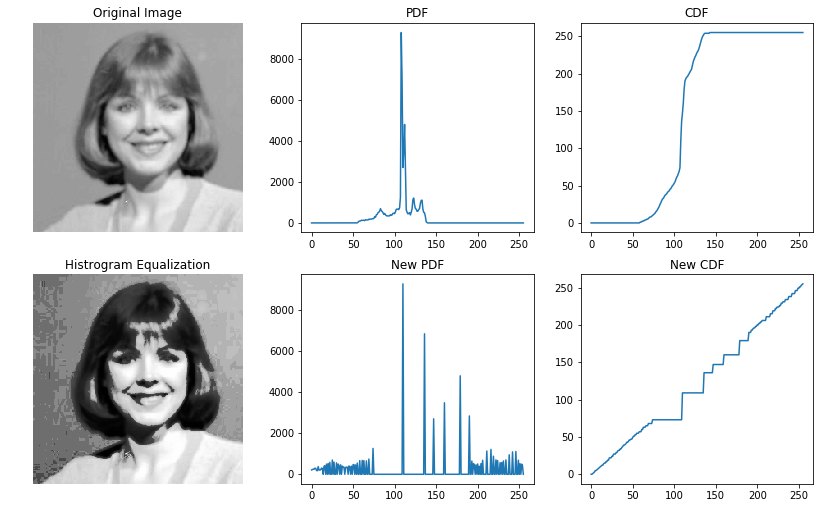

In [86]:

images_path=r'.\input_data'
images=['hist_equal.jpg','contrast6.jpg','lung.jpg','blonde.jpg']
images=[os.path.join(images_path,filename) for filename in images]

# imge_path='A1_resources/DIP_2019_A1/hist_equal.jpg'
for imge_path in images:
    image = cv2.imread(imge_path,0)

    new_image=histEqualization(image)

    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9)

    plt.subplot(2,3,1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(image,cmap='gray')

    plt.subplot(2,3,2)
    plt.title("PDF")
    #plt.axis('off')
    hist_ori = getHistogram(image)
    plt.plot(hist_ori)

    plt.subplot(2,3,3)
    plt.title("CDF")
    #plt.axis('off')
    cum_hist_ori = getCDF(hist_ori)
    plt.plot(cum_hist_ori)

    plt.subplot(2,3,4)
    plt.title("Histrogram Equalization")
    plt.axis('off')
    plt.imshow(new_image,cmap='gray')

    plt.subplot(2,3,5)
    plt.title("New PDF")
    #plt.axis('off')
    hist_new = getHistogram(new_image)
    plt.plot(hist_new)

    plt.subplot(2,3,6)
    plt.title("New CDF")
    #plt.axis('off')
    cum_hist_new = getCDF(hist_new)
    plt.plot(cum_hist_new)

    plt.show()   


cols = len(images)
num=0

1. This method increased the global contrast of many images, especially when the usable data of the image is represented by close contrast values
1. Dark pixels in range 0-50( Close contrast  are now mapped to a wider range (Better contrast) in new image. 
1. Histogram equalization is causing uniform distribution
1. The method is useful in images with backgrounds and foregrounds that are both bright or both dark. 
1. In the last image histogram equilization did not work as frequnecy distribution is not concentrated at both bright or both dark                           


** Write a function histMatching which takes an input image and a reference image
and applies histogram Matching on the input image by matching the histogram with
that of the reference image. Use eye.png and eyeref.png (converted to grayscale)
as the input and reference images respectively. **

In [87]:
def histMatching(im1,im2):

    h,w = im1.shape

    hist1 = getHistogram(im1)
    cum_hist1 =getCDF(hist1)

    hist2 = getHistogram(im2)
    cum_hist2 =getCDF(hist2)
    
    pixels = np.arange(256)
    new_pixels = np.interp(cum_hist1, cum_hist2, pixels) 
    new_im = (np.reshape(new_pixels[im1.ravel()], im1.shape)).astype(np.uint8)

    return  new_im

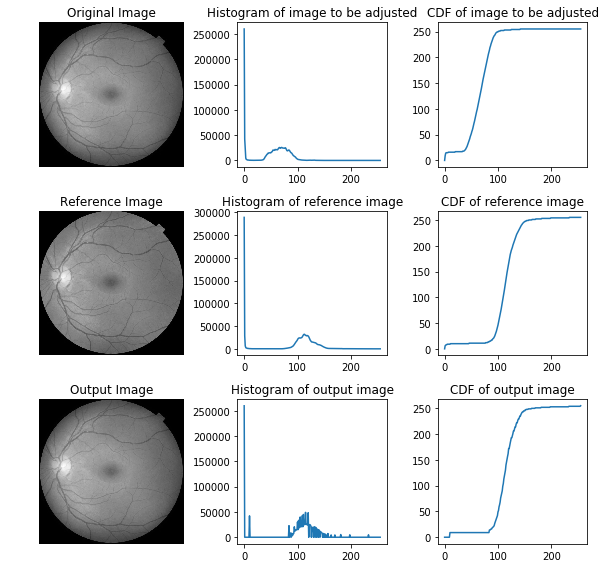

In [88]:
imge_path1='.\input_data\eye.png'
im1 = cv2.imread(imge_path1,0)

imge_path2='.\input_data\eyeref.png'
im2 = cv2.imread(imge_path2,0)

new_image=histMatching(im1,im2)

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.5, right=1.2, top=1.2)

#Original
plt.subplot(3,3,1)
plt.title("Original Image")
plt.axis('off')
plt.imshow(im1,cmap='gray')

plt.subplot(3,3,2)
plt.title("Histogram of image to be adjusted")
#plt.axis('off')
hist_ori = getHistogram(im1)
plt.plot(hist_ori)

plt.subplot(3,3,3)
plt.title("CDF of image to be adjusted")
#plt.axis('off')
cdf_ori = getCDF(hist_ori)
plt.plot(cdf_ori)

#Reference
plt.subplot(3,3,4)
plt.title("Reference Image")
plt.axis('off')
plt.imshow(im2,cmap='gray')

plt.subplot(3,3,5)
plt.title("Histogram of reference image")
#plt.axis('off')
hist_ref = getHistogram(im2)
plt.plot(hist_ref)

plt.subplot(3,3,6)
plt.title("CDF of reference image")
#plt.axis('off')
cdf_ref = getCDF(hist_ref)
plt.plot(cdf_ref)

#output
plt.subplot(3,3,7)
plt.title("Output Image")
plt.axis('off')
plt.imshow(im1,cmap='gray')

plt.subplot(3,3,8)
plt.title("Histogram of output image")
#plt.axis('off')
hist_new = getHistogram(new_image)
plt.plot(hist_new)

plt.subplot(3,3,9)
plt.title("CDF of output image")
#plt.axis('off')
cdf_new = getCDF(hist_new)
plt.plot(cdf_new)

plt.tight_layout()
plt.show()   

** You are provided with 4 images (part1.png, part2.png, part3.png, part4.png)
with different contrast levels which correspond to four quadrants of canyon.png as
shown in Figure 5. Retrieve the original image(converted to grayscale) using these
four images(converted to grayscale) as closely as possible. **

Matching  .\input_data\part2.png
Matching  .\input_data\part3.png
Matching  .\input_data\part4.png


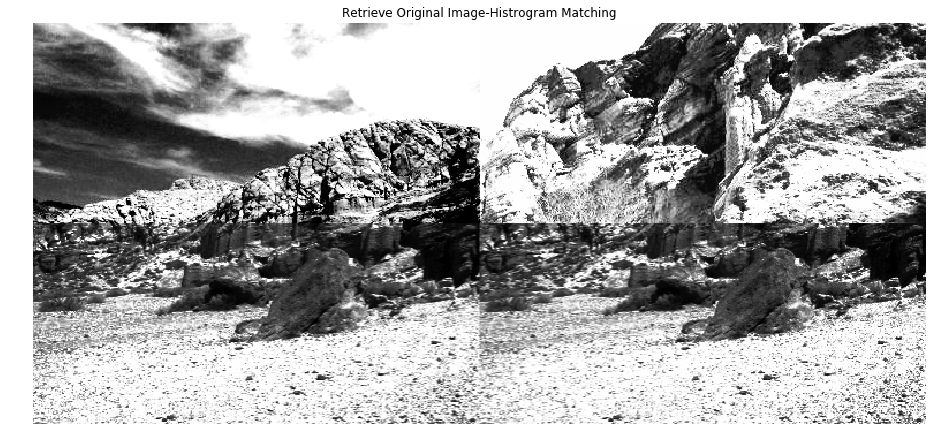

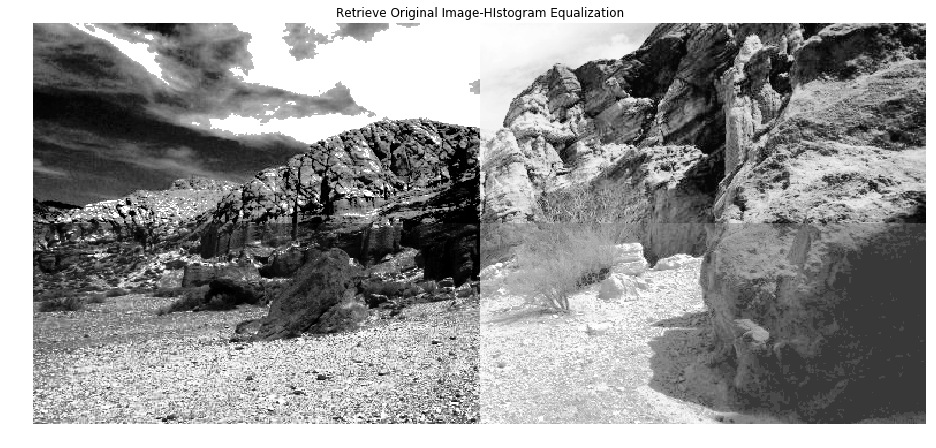

In [90]:
reference_image_path='.\input_data\part1.png'
reference_image = cv2.imread(reference_image_path,0)

images_path=r'.\input_data'
images=['part2.png','part3.png','part4.png']
images=[os.path.join(images_path,filename) for filename in images]

matched_images=[]
for imge_path in images:
    image = cv2.imread(imge_path,0)
    print('Matching ',imge_path)
    new_image=histMatching(image,reference_image)
#    new_image=histEqualization(image)
    matched_images.append(new_image)
    
top=cv2.hconcat([reference_image,matched_images[0]])
bottom=cv2.hconcat([matched_images[1],matched_images[1]])

h,w =top.shape

bottom = cv2.resize(bottom, (w,h), interpolation = cv2.INTER_AREA)
fig = plt.figure(figsize=(16,16))

mosaic=cv2.vconcat([top,bottom])
plt.title("Retrieve Original Image-Histrogram Matching")
plt.imshow(mosaic,cmap='gray')
plt.axis('off')
plt.show()   

fig = plt.figure(figsize=(16,16))
tl=histEqualization(reference_image)
tr=histEqualization(cv2.imread(images[0],0))
bl=histEqualization(cv2.imread(images[1],0))
br=histEqualization(cv2.imread(images[2],0))

top=cv2.hconcat([tl,tr])
bottom=cv2.hconcat([bl,br])

h,w =top.shape

bottom = cv2.resize(bottom, (w,h), interpolation = cv2.INTER_AREA)

mosaic=cv2.vconcat([top,bottom])
plt.title("Retrieve Original Image-HIstogram Equalization")
plt.imshow(mosaic,cmap='gray')
plt.axis('off')
plt.show() 



#  <center>Question 7 - Histogram Transformation </center>

** Choose an image of your choice and apply histogram equalization to it. Apply histogram equalization to the resulting image and compare the two images. What are your observations? **

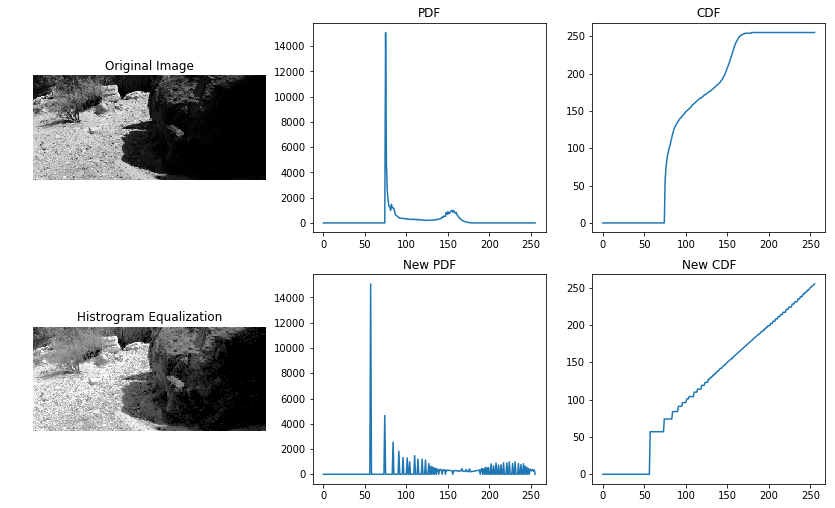

After applying histogram equalization to the resulting image 


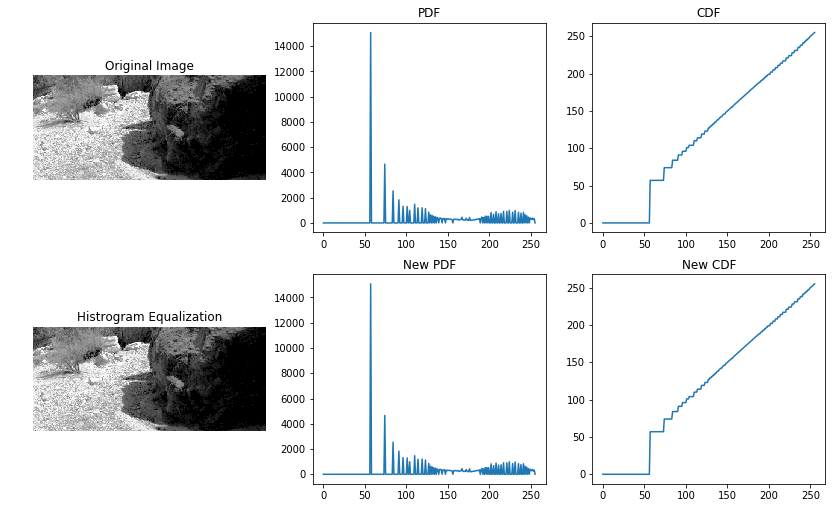

The images have same size and channels
The images are completely Equal


In [91]:

def displayhistEqualization(image ):

    new_image=histEqualization(image)

    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(bottom=0.1, right=1.5, top=0.9)

    plt.subplot(2,3,1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(image,cmap='gray')

    plt.subplot(2,3,2)
    plt.title("PDF")
    #plt.axis('off')
    hist_ori = getHistogram(image)
    plt.plot(hist_ori)

    plt.subplot(2,3,3)
    plt.title("CDF")
    #plt.axis('off')
    cum_hist_ori = getCDF(hist_ori)
    plt.plot(cum_hist_ori)

    plt.subplot(2,3,4)
    plt.title("Histrogram Equalization")
    plt.axis('off')
    plt.imshow(new_image,cmap='gray')

    plt.subplot(2,3,5)
    plt.title("New PDF")
    #plt.axis('off')
    hist_new = getHistogram(new_image)
    plt.plot(hist_new)

    plt.subplot(2,3,6)
    plt.title("New CDF")
    #plt.axis('off')
    cum_hist_new = getCDF(hist_new)
    plt.plot(cum_hist_new)

    plt.show()  
    
    return new_image

        
image_path1=r'A1_resources\DIP_2019_A1\contrast6.jpg'
image1 = cv2.imread(image_path1,0)
new_image1=displayhistEqualization(image)

print('After applying histogram equalization to the resulting image ')
new_image2=displayhistEqualization(new_image1)

def isequal(im1,im2):
    
    if im1.shape == im2.shape:
        print("The images have same size and channels")
    difference = cv2.subtract(im1, im2)
   
    if cv2.countNonZero(difference) == 0:
        print("The images are completely Equal")
        
isequal(new_image1,new_image2)        

** Pick the following combination of images and perform histogram transformation on
them. **
1. • Similar Histograms
1. • Dark ->Light Image
1. • Light ->Dark Image 

In [92]:
def HistogramTransfer(im1,im2):

	new_image=histMatching(im1,im2)

	plt.figure(figsize=(8, 8))
	plt.subplots_adjust(bottom=0.5, right=1.2, top=1.2)

	#Original
	plt.subplot(3,3,1)
	plt.title("Original Image")
	plt.axis('off')
	plt.imshow(im1,cmap='gray')

	plt.subplot(3,3,2)
	plt.title("Histogram of image to be adjusted")
	#plt.axis('off')
	hist_ori = getHistogram(im1)
	plt.plot(hist_ori)

	plt.subplot(3,3,3)
	plt.title("CDF of image to be adjusted")
	#plt.axis('off')
	cdf_ori = getCDF(hist_ori)
	plt.plot(cdf_ori)

	#Reference
	plt.subplot(3,3,4)
	plt.title("Reference Image")
	plt.axis('off')
	plt.imshow(im2,cmap='gray')

	plt.subplot(3,3,5)
	plt.title("Histogram of reference image")
	#plt.axis('off')
	hist_ref = getHistogram(im2)
	plt.plot(hist_ref)

	plt.subplot(3,3,6)
	plt.title("CDF of reference image")
	#plt.axis('off')
	cdf_ref = getCDF(hist_ref)
	plt.plot(cdf_ref)

	#output
	plt.subplot(3,3,7)
	plt.title("Output Image")
	plt.axis('off')
	plt.imshow(im1,cmap='gray')

	plt.subplot(3,3,8)
	plt.title("Histogram of output image")
	#plt.axis('off')
	hist_new = getHistogram(new_image)
	plt.plot(hist_new)

	plt.subplot(3,3,9)
	plt.title("CDF of output image")
	#plt.axis('off')
	cdf_new = getCDF(hist_new)
	plt.plot(cdf_new)

	plt.tight_layout()
	plt.show()   

Light-->Dark


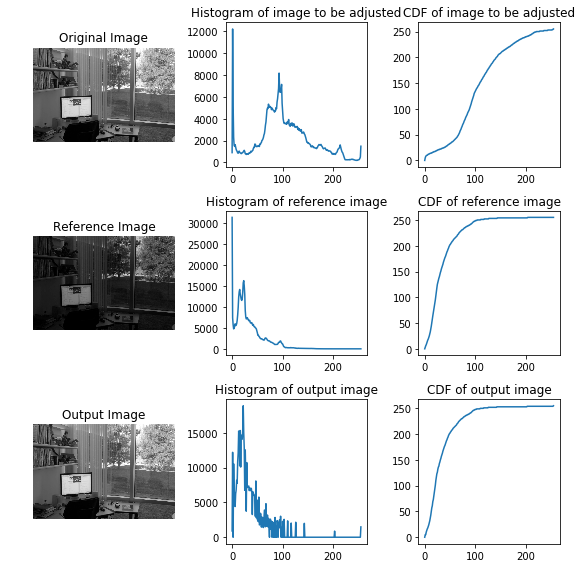

In [93]:
imge_path1='.\input_data\office_4.jpg' # Dark Image
im1 = cv2.imread(imge_path1,0)

imge_path2='.\input_data\\office_2.jpg'  #Reference light image
im2 = cv2.imread(imge_path2,0)

print('Light-->Dark')
new_image=HistogramTransfer(im1,im2)

Similar


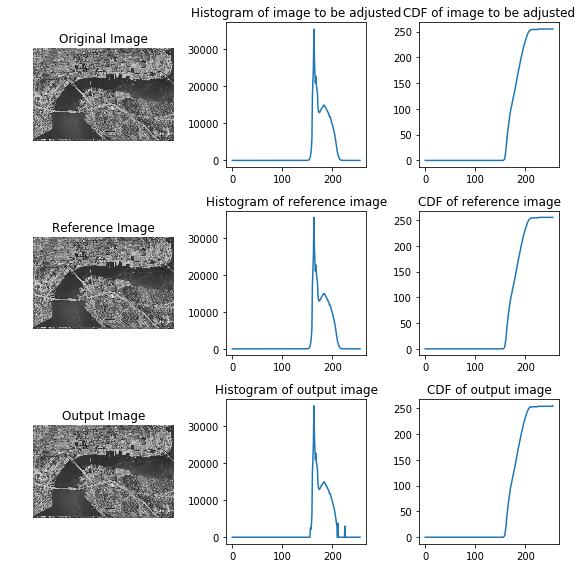

In [94]:
imge_path1='.\input_data\contrast3.jpg'
im1 = cv2.imread(imge_path1,0)

imge_path2='.\input_data\contrast3.jpg'
im2 = cv2.imread(imge_path2,0)

print('Similar')
new_image=HistogramTransfer(im1,im2)

Light-->Dark


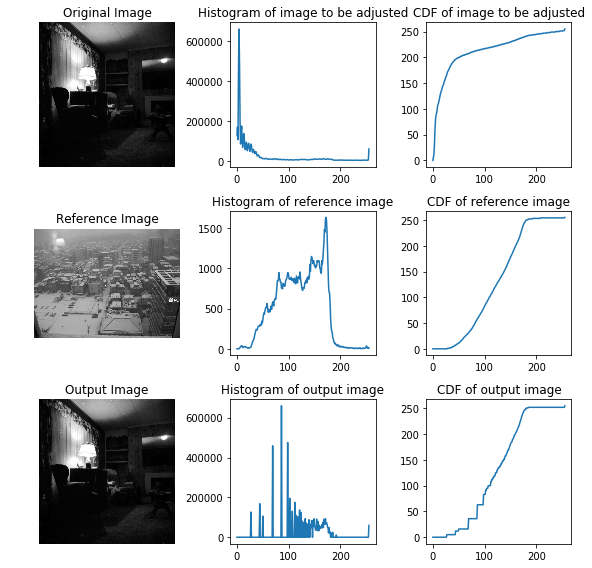

In [95]:
imge_path1='.\input_data\hist_equal.jpg'
im1 = cv2.imread(imge_path1,0)

imge_path2='.\input_data\light_reference.jpg'
im2 = cv2.imread(imge_path2,0)

print('Light-->Dark')
new_image=HistogramTransfer(im1,im2)